This notebook generates a model for review sentiment.
Let's mount Google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


The following are commands to get the dataset. We do not need them, since we have already downloaded the dataset.

In [0]:
#!wget --no-check-certificate \
#    https://raw.githubusercontent.com/KeithGalli/sklearn/master/data/sentiment/Books_small_10000.json \
#    -O /tmp/reviews.json
#!wget --no-check-certificate \
#    http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Books_5.json.gz \
#    -O '/content/drive/My Drive/Colab Notebooks/reviews.json.gz'

Let's decompress the dataset from Google Drive to the /tmp folder.

In [0]:
!gunzip -c '/content/drive/My Drive/Colab Notebooks/reviews.json.gz' > /tmp/reviews.json

Let's import some libraries and check the Tensorflow version.

In [4]:
import json
import tensorflow as tf
import numpy as np

print(tf.__version__)

2.2.0


Let's read the file and split the data into training and testing examples. We convert words to numbers by using the tokenizer. Finally we pad our sequences to make them of the same length.

In [8]:
!cp '/content/drive/My Drive/Colab Notebooks/preprocess.py' .
from preprocess import Sentences2Sequences

reviews_num = 300000
embedding_dim = 100
training_portion = .9

with open("/tmp/reviews.json", 'r') as f:
  sentences = []
  labels = []
  neg = 0
  pos = 0
  for line in f:
    item = json.loads(line)
    valid = ('reviewText' in item) and ('overall' in item)
    if valid:
      sentence = item['reviewText']
      sentences.append(sentence)
      is_positive = item['overall'] > 2.5
      if is_positive:
        pos += 1
      else:
        neg += 1
      labels.append(int(is_positive))
    if len(sentences) == reviews_num:
      break

print('Number of reviews: ', len(sentences))
print('Number of negative reviews: ', neg)
print('Number of positive reviews: ', pos)
tot = neg + pos

training_size = int(training_portion * len(sentences))
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

preprocessor = Sentences2Sequences()
training_padded = preprocessor.preprocess(training_sentences)
vocab_size = len(preprocessor._tokenizer.word_index)
print("Vocabulary size: ",vocab_size)
testing_padded = preprocessor.preprocess(testing_sentences)

Number of reviews:  300000
Number of negative reviews:  23436
Number of positive reviews:  276564
Vocabulary size:  154172


We will use the 100 dimension version of GLOVE as our first Embedding layer of our model.

In [10]:
# Note this is the 100 dimension version of GloVe from Stanford
# Laurence Moroney unzipped and hosted it on his site to make the notebook easier
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in preprocessor._tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2020-05-18 14:22:54--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 2607:f8b0:400e:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   140MB/s    in 2.4s    

2020-05-18 14:22:57 (140 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



Our dataset is imbalanced, since we have only a few negative reviews. We will take this into account by 'paying more attention' to negative reviews.

In [11]:
weight_for_0 = tot/neg/2.0 
weight_for_1 = tot/pos/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 6.40
Weight for class 1: 0.54


Let's compile the model and get its summary.

In [14]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
      vocab_size + 1,
      embedding_dim,
      input_length = preprocessor._max_length,
      weights=[embeddings_matrix],
      trainable=False),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 100)          15417300  
_________________________________________________________________
dropout (Dropout)            (None, 120, 100)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                34048     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 15,453,461
Trainable params: 36,161
Non-trainable params: 15,417,300
_________________________________________________________________


Let's train our model.

In [15]:
num_epochs = 10
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)
history = model.fit(
  training_padded,
  training_labels,
  epochs=num_epochs,
  validation_data=(testing_padded, testing_labels),
  class_weight = class_weight,
  verbose=1)


Epoch 1/10
8438/8438 [==============================] - 102s 12ms/step - loss: 0.4849 - accuracy: 0.7414 - val_loss: 0.3681 - val_accuracy: 0.8334
Epoch 2/10
8438/8438 [==============================] - 102s 12ms/step - loss: 0.4149 - accuracy: 0.7922 - val_loss: 0.3585 - val_accuracy: 0.8360
Epoch 3/10
8438/8438 [==============================] - 103s 12ms/step - loss: 0.3941 - accuracy: 0.8036 - val_loss: 0.3786 - val_accuracy: 0.8238
Epoch 4/10
8438/8438 [==============================] - 102s 12ms/step - loss: 0.3820 - accuracy: 0.8113 - val_loss: 0.4395 - val_accuracy: 0.7927
Epoch 5/10
8438/8438 [==============================] - 100s 12ms/step - loss: 0.3719 - accuracy: 0.8185 - val_loss: 0.3539 - val_accuracy: 0.8270
Epoch 6/10
8438/8438 [==============================] - 100s 12ms/step - loss: 0.3633 - accuracy: 0.8215 - val_loss: 0.2882 - val_accuracy: 0.8722
Epoch 7/10
8438/8438 [==============================] - 99s 12ms/step - loss: 0.3578 - accuracy: 0.8259 - val_loss: 0.

Let's inspect some training metrics.

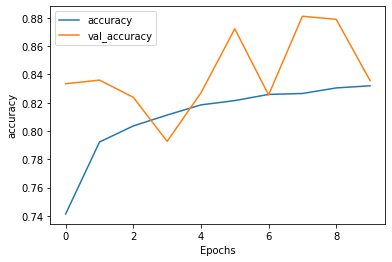

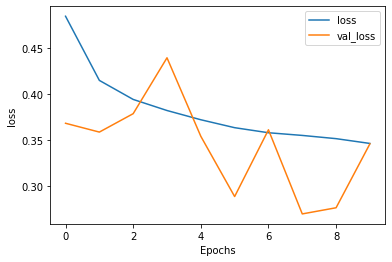

In [16]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

Now we can use our model to predict and see how it performs. Note that we need to preprocess our reviews the same way as we did with the training examples.

In [17]:
new_reviews = ["This book was very easy to read. I really enjoyed it.", "I would not recommend this book to anyone", "This book is not interesting","I am sure this book is chalk full of good info! However it is certainly not a beginners book to investing. If you're like me and have no idea what the definition of terms like 'net tangible assets', and 'sub working capital' are it may be best to find a true beginners book as a prequel to this one. Lots of good info I cant yet understand."]
new_reviews_padded = preprocessor.preprocess(new_reviews)
predictions = model.predict(new_reviews_padded)
print(predictions)

[[0.99412656]
 [0.04156011]
 [0.04869186]
 [0.04009876]]


Let's have the model's predictions on the testing samples and plot the ROC curve. We find the optimal output threshold, which maximizes the Youden's J statistic.

In [0]:
predictions = model.predict(testing_padded)

0.44388688


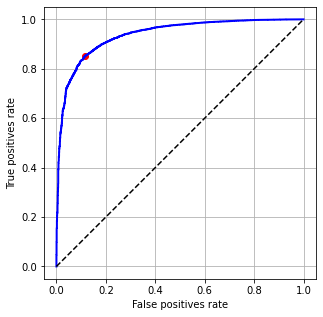

In [19]:
import sklearn.metrics

def plot_roc(name, labels, predictions, **kwargs):
  fpr, tpr, thresholds = sklearn.metrics.roc_curve(labels, predictions)
  plt.plot(fpr, tpr, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives rate')
  plt.ylabel('True positives rate')
  plt.grid(True)
  # Youden's J statistic
  J = tpr - fpr
  ix = np.argmax(J)
  best_threshold = thresholds[ix]
  plt.plot([0,1], [0,1], linestyle='--', color='k', label='No Skill')
  plt.scatter(fpr[ix], tpr[ix], marker='o', color='r', label='Best')
  ax = plt.gca()
  ax.set_aspect('equal')
  return best_threshold

plt.figure(figsize=(5,5))
best_threshold = plot_roc(
  "LSTM bidirectional",
  testing_labels,
  predictions,
  color='b')
print(best_threshold)

Let's save the preprocessor and the model.

In [0]:
import pickle
with open('/content/drive/My Drive/Colab Notebooks/preprocessor.pkl', 'wb') as handle:
    pickle.dump(preprocessor, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open( 'word_index.json' , 'w' ) as file:    
    json.dump( preprocessor._tokenizer.word_index , file)
model.save('/content/drive/My Drive/Colab Notebooks/amazon_reviews_sentiment.h5')

Let's install Tensorflow.js.

In [21]:
!pip install tensorflowjs

     |████████████████████████████████| 61kB 3.0MB/s 
     |████████████████████████████████| 144.4MB 101kB/s 
     |████████████████████████████████| 92kB 13.3MB/s 
     |████████████████████████████████| 256kB 58.0MB/s 
     |████████████████████████████████| 921kB 49.8MB/s 
  Created wheel for PyInquirer: filename=PyInquirer-1.0.3-cp36-none-any.whl size=32851 sha256=9d30c59f0b1bd8d4f527f6348220851264ec8dac89f5e87187dd7c9364789848
  Stored in directory: /root/.cache/pip/wheels/52/6c/b1/3e4b0e8daf42a92883c7641c0ea8ffb62e0490ebed2faa55ad
Successfully built PyInquirer
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Found existing installation: Pygments 2.1.3
    Uninstalling Pygments-2.1.3:
      Successfully uninstalled Pygments-2.1.3
  Found existing installation: tensorflow-hub 

We use Tensorflow.js to convert our model to JSON format and zip it for download. This way our model can be loaded in a webpage using Javascript.

In [22]:
# import tensorflowjs as tfjs
# tfjs.converters.save_keras_model(model, 'model')
!cp '/content/drive/My Drive/Colab Notebooks/amazon_reviews_sentiment.h5' .
!tensorflowjs_converter --input_format=keras_saved_model amazon_reviews_sentiment.h5 model/
!zip -r /content/model.zip model/

2020-05-18 14:54:15.786166: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-05-18 14:54:15.790223: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2200000000 Hz
2020-05-18 14:54:15.790413: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2d7aa00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-05-18 14:54:15.790446: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
  adding: model/ (stored 0%)
  adding: model/group1-shard10of15.bin (deflated 74%)
  adding: model/group1-shard12of15.bin (deflated 76%)
  adding: model/group1-shard3of15.bin (deflated 20%)
  adding: model/group1-shard2of15.bin (deflated 15%)
  adding: model/group1-shard11of15.bin (deflated 74%)
  adding: model